In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#point-based estimate
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#interval-based estimate
import pystan
import arviz as az

#animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython import display
plt.rcParams['animation.ffmpeg_path'] = 'utils/ffmpeg'

In [ ]:
#point-based estimated best
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 5.95605924e+00, 3.46957143e-09, 2.99296531e+02, 5.36128135e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1., 36.84876916, 30.33289918, 156.72063863, 156.06142356],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 15.99371476, 6.8959355, 380.68087314, 387.7069378],
    'e20x32gp411': [12.53828935, 1., 2.78451886, 1.49241488, 8.39069666, 27.77880598, 314.77726787, 311.65818168],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 15.2982435, 11.91592347, 342.96437349, 343.5314864],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 3.4673668, 20.82148359, 307.13693296, 290.48137472],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 26.05989294, 20.59322098, 218.62810381, 218.64413488],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1., 21.72980962, 19.19063999, 277.09322359, 275.39980816],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 22.82771137, 18.70845616, 228.18083668, 227.98611955]
}

#### OD data

In [ ]:
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
all_gates = list(set([i[:-3] for i in ods.columns.tolist()]))
gates = [g for g in all_gates if g not in ['blank', 'positive_control', 'negative_control']]

Read od parameters.

In [ ]:
od_params = {}
for gate in gates:
    od_params[gate] = pd.read_csv('datasets/stan_ods/' + gate + '.csv')['mean'][[0, 1, 3]].tolist()
od_params

In [ ]:
def growth_rate(OD, r, c):
    return (r * (1 - (OD/c)))

def od_inference(t, r, c, y0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(OD[0], r, c) * OD[0]
        return dOD
    
    solution = odeint(od_model, y0, t, (r, c))
    return np.array(solution.T[0])

In [ ]:
gate = 'e42x32STIMPDH1'
od = ods.loc[:, ods.columns.str.startswith(gate)].iloc[:,3]
plt.plot(ods.index/60, od_inference(ods.index, *sampled), label='predicted', c='purple', linewidth=2.5)
plt.scatter(ods.index/60, od, label='real', s=10, c='gray')
sns.despine()

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(12, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(gates):
        od = ods.loc[:, ods.columns.str.startswith(gates[i])].iloc[:,3]
        ax.plot(ods.index/60, od_inference(ods.index, *od_params[gates[i]]), label='predicted', c='purple', linewidth=2.5)
        ax.scatter(ods.index/60, od, label='real', s=10, c='gray')
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fluorescence data.

In [2]:
def plot_trace(param, param2, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    plt.figure(figsize=(10, 6))

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    mean2 = np.mean(param2)
    median2 = np.median(param2)
    cred_min2, cred_max2 = np.percentile(param2, 2.5), np.percentile(param2, 97.5)

    # Plotting
    plt.subplot(2,2,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    #plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,2,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    # Plotting
    plt.subplot(2,2,3)
    plt.plot(param2)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean2, color='r', lw=2, linestyle='--')
    plt.axhline(median2, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min2, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max2, linestyle=':', color='k', alpha=0.2)
    #plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,2,4)
    plt.hist(param2, 30, density=True); sns.kdeplot(param2, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean2, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median2, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min2, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max2, linestyle=':', color='k', alpha=0.2)
    
    plt.suptitle(param_name)

    plt.tight_layout()
    plt.legend()
    plt.show()

### Hill Function

In [ ]:
loaded = az.from_netcdf('datasets/stan_hills/PyStan3-Hill-e42x32STIMPDH1-new-001.nc')
#az.plot_trace(loaded, figsize=(6, 4))
#sns.despine()

In [ ]:
az.plot_trace(loaded, figsize=(6, 4))
sns.despine()

In [ ]:
plot_trace(np.array(loaded['posterior']['sigma'][8]), np.array(loaded['posterior']['sigma'][9]), 'sigma')

In [ ]:
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])

In [ ]:
plot_trace(thetas[7][6], thetas[7][7], 'theta0')

#### Simple Model

In [3]:
loaded = az.from_netcdf('datasets/alternative/PyStan3-Alternative-e41x32NrdJ1-003.nc')
#az.plot_trace(loaded, figsize=(6, 4))
#sns.despine()

In [ ]:
az.plot_trace(loaded, figsize=(6, 4))
sns.despine()

In [4]:
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])

In [ ]:
plot_trace(np.array(loaded['posterior']['y0'][0]), np.array(loaded['posterior']['y0'][1]), 'y0')

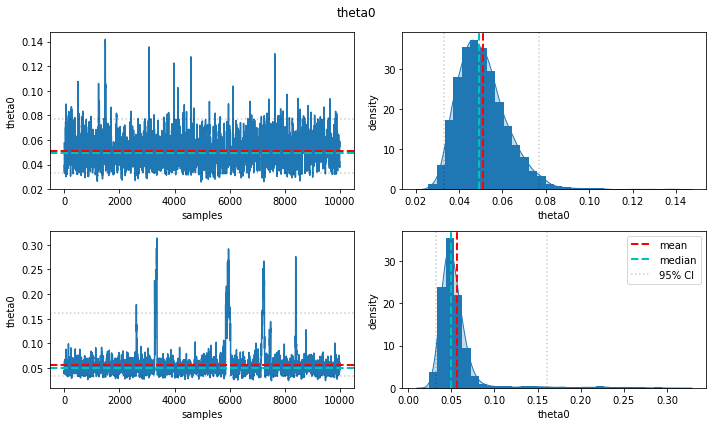

In [7]:
plot_trace(thetas[0][8], thetas[0][9], 'theta0')

In [ ]:
plot_trace(thetas[0][2], thetas[0][3], 'theta0')

In [ ]:
plot_trace(thetas[0][4], thetas[0][5], 'theta0')

In [ ]:
plot_trace(thetas[0][6], thetas[0][7], 'theta0')

In [ ]:
plot_trace(thetas[1][8], thetas[1][9], 'theta0')

In [ ]:
f_params = [thetas[m][1][100] for m in range(len(thetas))]

In [ ]:
f_params

In [ ]:
od_params = {
    'e16x33NrdA2': [0.0148194554039306, 1.2408917618889663, 0.0251889022569271],
    'e42x32STIMPDH1': [0.013165608798406, 1.278935730092542, 0.0216016431163906],
    'e32x30SspGyrB': [0.0159760283755244, 1.150249628464946, 0.0196547733645749],
    'e11x32STPhoRadA': [0.0070462352099844, 1.1229375761211622, 0.0973103761235306],
    'e34x30MjaKlbA': [0.0139910399333654, 1.147632550566836, 0.0235340568336425],
    'e41x32NrdJ1': [0.0136188162357974, 1.2375665371324622, 0.0300644005159601],
    'e20x32gp411': [0.0155212086766198, 1.2780552798586051, 0.0193773015388865],
    'e38x32gp418': [0.0155869734557929, 1.2060333912302554, 0.0247131234412902],
    'e15x32NpuSspS2': [0.0158706098949703, 1.1961969417584624, 0.0235672266874314]
}

In [ ]:
params = {'bn': [1e-1, 0, 1e1],
    'bc': [1e-1, 0, 1e1],
    'bg': [1e-2, 0, 1e1],
    'syn_ECFn': [4e0, 0, 1e2],
    'syn_ECFc': [4e0, 0, 1e2],
    'syn_ECF': [50e-10, 0, 1e-4],
    'deg': [7e-3, 0, 1e-1],
    'syn_GFP': [1e4, 0, 1e5],
    'deg_GFP': [1e-2, 0, 1e0],
    # 'a': [1e-2, 0, 1e1],
    'K': [1e-1, 0, 1e2],
    'n': [2e0, 0, 4],
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]}
pars = list(params.keys())

In [ ]:
#static model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

#growth curve
def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(t, OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

#model with auto-fluorescence term
def gate_wrapper_complete(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, a, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model without auto-fluorescence term
def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#model only auto-fluorescence term
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def gate_wrapper_gfp(t, syn_GFP, deg_GFP, extra, y0):
    
    def gate_model(y, t):
        
        GFP, OD = y
        alpha, beta = extra
        
        gamma = growth_rate(t, OD, alpha, beta)
        dOD = gamma * OD
        dGFP = syn_GFP - (deg_GFP + gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

In [ ]:
gate = 'e42x32STIMPDH1'
print(gate)
fluo = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]

In [ ]:
def fit_single_state(fluo, f_params, od_params, ind1, ind2):
    
    num_od_params = 3
    num_vars = 4
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, (od_params[0], od_params[1]), pd.Series(np.append(np.zeros(num_vars), od_params[2])))
        return pd.Series(fit[3])
    
    f_sim = model_fit(fluo.index, *f_params)
    
    return f_sim, fluo.index, fluo

a, b, c = fit_single_state(fluo, f_params, od_params[gate], 1, 1)

In [ ]:
tests = []
for k in range(100):
    f_params = [thetas[m][1][k] for m in range(len(thetas))]
    a, b, c = fit_single_state(fluo, f_params, od_params[gate], 1, 1)
    plt.plot(b/60, a, color='darkred')
#plt.plot(b/60, c, color='gray')
plt.title(gate)
sns.despine()

In [ ]:
plt.plot(b/60, a, color='darkred')
plt.scatter(b/60, c, color='gray', s=10)
plt.title(gate)
sns.despine()

In [ ]:
m = 8
plot_trace(thetas[m][0], thetas[m][1], pars[m])

In [ ]:
sns.pairplot(pd.DataFrame([t[0] for t in thetas]).T, corner=True)
plt.show()

In [ ]:
sns.pairplot(pd.DataFrame([t[1] for t in thetas]).T, corner=True)
plt.show()

In [ ]:
loaded = az.from_netcdf('datasets/stan_hills/Pystan3-Hill-e42x32STIMPDH1.nc')

In [ ]:
num_params = np.array(loaded['posterior']['theta']).shape[2]
thetas= []
for i in range(num_params):
    thetas.append(np.array(loaded['posterior']['theta'])[:,:,i])

In [ ]:
num_params

In [ ]:
sns.pairplot(pd.DataFrame([t[1] for t in thetas]).T, corner=True)
plt.show()

In [ ]:
sns.pairplot(pd.DataFrame([t[1] for t in thetas]).T, corner=True)
plt.show()

In [ ]:
plot_trace(thetas[0][0], thetas[0][1], 'theta0')

In [ ]:
plot_trace(thetas[1][0], thetas[1][1], 'theta1')

In [ ]:
plot_trace(thetas[2][0], thetas[2][1], 'theta1')

In [ ]:
plot_trace(thetas[3][0], thetas[3][1], 'theta1')

In [ ]:
plot_trace(thetas[4][0], thetas[4][1], 'theta1')

In [ ]:
fluo_t[['cuma', 'ara', 1440]]

In [ ]:
fluo_t[1440].values

In [ ]:
fluo_pvt.values.ravel()

#### Alternative Kinetics Modeling

In [ ]:
fluos = pd.read_csv('datasets/induction_matrix/induction_fluo.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cuma_list = [0, 6.25, 12.5, 25, 50, 100]
ara_list = [0, 0.8125, 3.25, 13, 52, 208]

gate = 'e42x32STIMPDH1'
at_m = 1440

fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
#fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', at_m)

In [ ]:
model = """
    functions {
        real hill_activation(real x, real K, real n, real ymin, real ymax) {
            real hill;
            hill = ymin + (ymax - ymin) * (pow(x, n) / (pow(K, n) + pow(x, n)));
            return hill;
        }
        real[] hill_activation_and(real[] x1, real[] x2, real[] theta, int T) {
            
            real K1 = theta[1];
            real K2 = theta[2];
            real n1 = theta[3];
            real n2 = theta[4];
            real ymin1 = theta[5];
            real ymin2 = theta[6];
            real ymax1 = theta[7];
            real ymax2 = theta[8];
            real hill[T];
            for (t in 1:T) {
                hill[t] = hill_activation(x1[t], K1, n1, ymin1, ymax1) + hill_activation(x2[t], K2, n2, ymin2, ymax2);
            }
            return hill;
        }
    }
    data {
        int<lower=1> T;
        real x1[T];
        real x2[T];
        real y[T];
        real ymin;
        real ymax;
    }
    transformed data {
        real h = ymax - ymin;
    }
    parameters {
        real<lower=0> sigma;
        real<lower=0> theta[8];
    }
    model {
        real y_hat[T];
        sigma ~ normal(0, 0.1);
        theta[1] ~ uniform(1, 1e5);
        theta[2] ~ uniform(1, 4);
        theta[3] ~ uniform(0, ymin-0.5*h);
        theta[4] ~ uniform(0, ymax+0.5*h);
        theta[5] ~ uniform(1, 1e5);
        theta[6] ~ uniform(1, 4);
        theta[7] ~ uniform(0, ymin-0.5*h);
        theta[8] ~ uniform(0, ymax+0.5*h);
        y_hat = hill_activation_and(x1, x2, theta, T);
        y ~ normal(y_hat, sigma);
    }
"""

cuma_list = [0, 6.25, 12.5, 25, 50, 100]
ara_list = [0, 0.8125, 3.25, 13, 52, 208]
t = len(cuma_list) * len(ara_list)
x1, x2 = np.meshgrid(cuma_list, ara_list)
y = fluo_t[1440].values

data = {
    'T': t,
    'x1': x1.ravel(),
    'x2': x2.ravel(),
    'y': y,
    'ymin': y.min(),
    'ymax': y.max()
}

# Compile the model
sm = pystan.StanModel(model_code=model)
# Train the model and generate samples
fit = sm.sampling(data=data, iter=100, warmup=50, thin=1, chains=2, verbose=True)
print(fit)

In [ ]:
y = fluo_t[1440].values
h = y.max() - y.min()
y.max(), y.min(), h

#### Marionette Strains

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
all_gates = list(set([i[:-3] for i in fluos.columns.tolist()]))
gates = [g for g in all_gates if g not in ['blank', 'positive_control', 'negative_control']]

In [ ]:
sel = 0
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, fluos.columns.str.startswith(gate)]
fluo = fluo_sel.iloc[:,3]
od = od_sel.iloc[:,3]

Import OD parameters.

In [ ]:
od_params = {
    'e38x32gp418': [0.014832545686692651, 1.206999008636522, 0.05586756964448041],
    'e20x32gp411': [0.014610032725458771, 1.2772684500977902, 0.04458182544478886],
    'e11x32STPhoRadA': [0.007844653484011118, 1.1134153588014837, 0.10602396117757999],
    'e34x30MjaKlbA': [0.013408372081617236, 1.14628949032757, 0.052259068950788926],
    'e32x30SspGyrB': [0.015133693377991284, 1.151731463297364, 0.04901732064094526],
    'e15x32NpuSspS2': [0.015778141196678447, 1.192983296185405, 0.049950021825183724],
    'e16x33NrdA2': [0.014463894907212425, 1.2421974135452174, 0.055150036439220534],
    'e41x32NrdJ1': [0.013145465488589058, 1.2385872370025641, 0.05941283831303974],
    'e42x32STIMPDH1': [0.012125122999895207, 1.2815026045141547, 0.0524312129470823],
}

In [ ]:
model = """
    functions {
        real[] logisticgrowth(real t,
                      real[] y,
                      real[] theta,
                      real[] x_r,
                      int[] x_i
                      ) {
            real dydt[x_i[1]];
            for (i in 1:x_i[1]){
                dydt[i] = theta[1] * y[i] * (1-y[i]/theta[2]);
            }
            return dydt;
        }
    }
    data {
        int<lower=1> T;
        int<lower=1> n_wells;
        real y0[n_wells];
        real z[T, n_wells];
        real t0;
        real ts[T];
    }
    transformed data {
        real x_r[0];
        int x_i[1];
        x_i[1] = n_wells;
    }
    parameters {
        real<lower=0> theta[2];
        real<lower=0> sigma;
    }
    model {
        real y_hat[T, n_wells];
        theta ~ cauchy(0,2.5);
        sigma ~ normal(0,0.01);
        y_hat = integrate_ode_rk45(logisticgrowth, y0, t0, ts, theta, x_r, x_i);
        for (t in 1:T) {
            for (i in 1:n_wells) {
                z[t,i] ~ normal(y_hat[t,i], sigma);
            }
        }
    }
"""

data = {
    'T': len(od),
    'n_wells': 1,
    'y0': [0.02],
    'z': od.values.reshape(-1, 1),
    't0': -20,
    'ts': od.index
}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=100, chains=2, n_jobs=1, verbose=True)
print(fit)

In [ ]:
model = """
    functions {
        real[] logisticgrowth(real t,
                      real[] y,
                      real[] theta,
                      real[] x_r,
                      int[] x_i
                      ) {
            real dydt[x_i[1]];
            for (i in 1:x_i[1]){
                dydt[i] = theta[1] * y[i] * (1-y[i]/theta[2]);
            }
            return dydt;
        }
    }
    data {
        int<lower=1> T;
        int<lower=1> n_wells;
        real y0[n_wells];
        real z[T, n_wells];
        real t0;
        real ts[T];
    }
    transformed data {
        real x_r[0];
        int x_i[1];
        x_i[1] = n_wells;
    }
    parameters {
        real<lower=0> theta[2];
        real<lower=0> sigma;
    }
    model {
        real y_hat[T, n_wells];
        theta ~ cauchy(0,2.5);
        sigma ~ normal(0,0.01);
        y_hat = integrate_ode_rk45(logisticgrowth, y0, t0, ts, theta, x_r, x_i);
        for (t in 1:T) {
            for (i in 1:n_wells) {
                z[t,i] ~ normal(y_hat[t,i], sigma);
            }
        }
    }
"""

data = {
    'T': len(od),
    'n_wells': 1,
    'y0': [0.02],
    'z': od.values.reshape(-1, 1),
    't0': -20,
    'ts': od.index
}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=100, chains=2, n_jobs=1, verbose=True)
print(fit)

In [ ]:
model = """
    functions {
        real[] growth(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
            real dydt[1];
            dydt[1] = theta[1] * y[1] * (1-y[1]/theta[2]);
            return dydt;
        }
    }
    data {
        int<lower=1> T;
        int<lower=1> n_states;
        //real y0[n_states];
        real y[T, n_states];
        real t0;
        real ts[T];
    }
    transformed data {
        real x_r[0];
        int x_i[0];
    }
    parameters {
        real<lower=0> theta[2];
        real<lower=0> y0[1];
        real<lower=0> sigma;
    }
    model {
        real y_hat[T, n_states];
        theta[1] ~ uniform(0, 1);
        theta[2] ~ uniform(0, 2);
        y0[1] ~ uniform(0, 0.1);
        sigma ~ normal(0, 0.2);
        y_hat = integrate_ode_rk45(growth, y0, t0, ts, theta, x_r, x_i);
        y[,1] ~ normal(y_hat[,1], sigma);
    }
"""

data = {
    'T': len(od),
    'n_states': 1,
    #'y0': [0.02],
    'y': od.values.reshape(-1, 1),
    't0': -20,
    'ts': od.index
}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=2, n_jobs=-1, verbose=True)
print(fit)

In [ ]:
fit.summary()

In [ ]:
sns.kdeplot(fit.extract()['theta'][:,0])
sns.despine()

In [ ]:
plt.plot(fit.extract()['sigma'])
sns.despine()

In [ ]:
import pickle
with open('datasets/first-stan.pkl', 'wb') as f:
    pickle.dump({'model': sm, 'fit': fit}, f)

In [ ]:
with open('datasets/first-stan.pkl', 'rb') as f:
    data_dict = pickle.load(f)
print(data_dict['fit'])

In [ ]:
az.plot_pair(fit)
plt.show()

In [ ]:
model = """
    data {
        int<lower=0> N;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha + beta * x, sigma);
    }
"""
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=100, chains=2, n_jobs=1)
print(fit)

In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

In [ ]:
df

In [ ]:
fit['theta[1]']

In [ ]:
alpha_mean, beta_mean = df['mean']['theta[1]'], df['mean']['theta[2]']

# Extracting traces
alpha = fit['theta[1]']
beta = fit['theta[2]']
sigma = fit['sigma']

In [ ]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    plt.gcf().tight_layout()
    plt.legend()

In [ ]:
plot_trace(alpha, 'alpha')

In [ ]:
plot_trace(sigma, 'sigma')

In [ ]:
plot_trace(lp, 'lp__')